# Présentation de la Layer Fusion by Octo

## Imports

In [1]:
import torch
import numpy as np
import pandas as pd
import copy
import sklearn.metrics
import os
import matplotlib.pyplot as plt

# set path the folder before
os.chdir("/Users/camille.hascoet/Documents/greenai/src/hale/clean/")

from green_ai.datasets import (
    get_cifar10,
    plot_cifar_images,
    make_validation_loader,
    is_balanced,
)

from green_ai.utils import (
    calculate_convlayer_out_size,
)

from typing import Tuple, List

import codecarbon


seed = 42
data_path = "/Users/camille.hascoet/Documents/greenai/src/hale/sandbox/data"

## Création des dataloaders

Files already downloaded and verified
Files already downloaded and verified


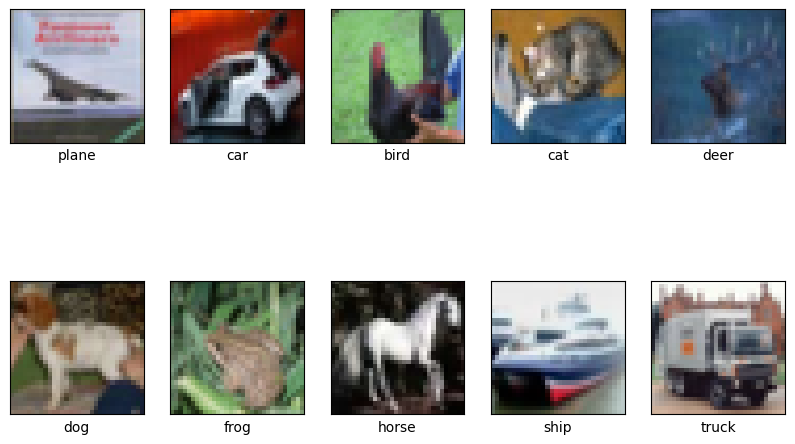

In [2]:
trainloader, testloader = get_cifar10(path=data_path, batch_size=32)
trainloader, valloader = make_validation_loader(
    train_loader=trainloader, validation_size=0.2
)

classes = (
    "plane",
    "car",
    "bird",
    "cat",
    "deer",
    "dog",
    "frog",
    "horse",
    "ship",
    "truck",
)

plot_cifar_images(classes=classes, trainloader=testloader)

In [4]:
print(len(trainloader.dataset))
print(len(valloader.dataset))

40000
10000


In [5]:
assert is_balanced(trainloader, epsilon=0.15)  # check if the dataset is balanced
assert is_balanced(valloader, epsilon=0.15)  # check if the dataset is balanced

# La classe ConvNet que nous utiliserons pour créer nos différents modèles

In [6]:
class ConvNet(torch.nn.Module):
    """
    Convolutional Neural Network model for image classification.

    Args:
        height (int): The height of the input image.
        width (int): The width of the input image.
        channels (int): The number of channels in the input image.
        num_classes (int): The number of classes for classification.
        extracted_features (int, optional): The number of extracted features in the convolutional layers. Defaults to 128.
        kernel_size (int, optional): The size of the convolutional kernel. Defaults to 3.
        stride (int, optional): The stride of the convolutional kernel. Defaults to 1.
        padding (int, optional): The padding of the convolutional kernel. Defaults to 0.
    """

    def __init__(
        self,
        height: int,
        width: int,
        channels: int,
        num_classes: int,
        extracted_features: int = 128,
        kernel_size: int = 3,
        stride: int = 1,
        padding: int = 0,
    ):
        super(ConvNet, self).__init__()
        self.conv1 = torch.nn.Conv2d(
            in_channels=channels,
            out_channels=extracted_features // 2,
            kernel_size=kernel_size,
            stride=stride,
            padding=padding,
        )
        height, width = calculate_convlayer_out_size(
            height=height,
            width=width,
            kernel_size=kernel_size,
            stride=stride,
            padding=padding,
            dilation=1,
            pooling_kernel_size=2,
            pooling_stride=2,
        )
        self.conv2 = torch.nn.Conv2d(
            in_channels=extracted_features // 2,
            out_channels=extracted_features,
            kernel_size=kernel_size,
            stride=stride,
            padding=padding,
        )
        height, width = calculate_convlayer_out_size(
            height=height,
            width=width,
            kernel_size=kernel_size,
            stride=stride,
            padding=padding,
            dilation=1,
            pooling_kernel_size=2,
            pooling_stride=2,
        )
        self.bn1 = torch.nn.BatchNorm2d(extracted_features // 2)
        self.bn2 = torch.nn.BatchNorm2d(extracted_features)

        self.pool = torch.nn.MaxPool2d(kernel_size=2, stride=2, padding=0)

        self.relu = torch.nn.ReLU()

        self.fc1 = torch.nn.Linear(
            in_features=extracted_features * height * width, out_features=64
        )
        self.fc2 = torch.nn.Linear(in_features=64, out_features=num_classes)

    def forward(self, x):
        x = self.pool(self.relu(self.bn1(self.conv1(x))))
        x = self.pool(self.relu(self.bn2(self.conv2(x))))
        x = x.view(x.size(0), -1)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [7]:
def train_model(
    model: torch.nn.Module,
    trainloader: torch.utils.data.DataLoader,
    valloader: torch.utils.data.DataLoader,
    criterion: torch.nn.Module,
    optimizer: torch.optim.Optimizer,
    num_epochs: int = 10,
    patience: int = 3,
):
    """
    Trains a given model using the provided data loaders and optimization parameters.

    Args:
        model (torch.nn.Module): The model to be trained.
        trainloader (torch.utils.data.DataLoader): The data loader for the training set.
        valloader (torch.utils.data.DataLoader): The data loader for the validation set.
        criterion (torch.nn.Module): The loss function used for training.
        optimizer (torch.optim.Optimizer): The optimizer used for training.
        num_epochs (int, optional): The number of epochs to train the model (default is 10).
        patience (int, optional): The number of epochs to wait for improvement in validation accuracy before early stopping (default is 3).

    Returns:
        tuple: A tuple containing the trained model, training losses, validation losses, and carbon emissions.

    """
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    train_losses = []
    val_losses = []
    tracker = codecarbon.EmissionsTracker(log_level="critical", save_to_file=False)
    tracker.start()
    for epoch in range(num_epochs):
        print(f"Epoch {epoch}/{num_epochs-1}")
        print("-" * 10)

        for phase in ["train", "val"]:
            if phase == "train":
                model.train()
                dataloader = trainloader
            else:
                model.eval()
                dataloader = valloader

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloader:
                optimizer.zero_grad()
                with torch.set_grad_enabled(phase == "train"):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    _, preds = torch.max(outputs, 1)

                    if phase == "train":
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloader.dataset)
            epoch_acc = running_corrects.double() / len(dataloader.dataset)

            print(f"{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")

            if phase == "val":
                if epoch_acc > best_acc:
                    best_acc = epoch_acc
                    best_model_wts = copy.deepcopy(model.state_dict())
                    patience = 3
                else:
                    patience -= 1
                    if patience == 0:
                        emissions = tracker.stop()
                        print(f"Early stopping, best val accuracy: {best_acc:.4f}")
                        model.load_state_dict(best_model_wts)
                        return model, train_losses, val_losses, emissions * 1000

            if phase == "val":
                val_losses.append(epoch_loss)
            else:
                train_losses.append(epoch_loss)

    emissions = tracker.stop()

    print(f"Best val Acc: {best_acc:4f}")

    model.load_state_dict(best_model_wts)

    return model, train_losses, val_losses, emissions * 1000

## Variables de base

In [3]:
EPOCHS = 1
for inputs, labels in trainloader:
    HEIGHT, WIDTH = inputs.shape[2:]
    CHANNELS = inputs.shape[1]
    break
N_CLASSES = len(classes)

## Training du modèle

In [ ]:
model = ConvNet(height=HEIGHT, width=WIDTH, channels=CHANNELS, num_classes=N_CLASSES)
model = model.to("cuda" if torch.cuda.is_available() else "cpu")

criterion = torch.nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

model, train_losses, val_losses, model_emissions = train_model(
    model, trainloader, valloader, criterion, optimizer, num_epochs=EPOCHS
)

In [12]:
def evaluate_model(
    model: torch.nn.Module,
    testloader: torch.utils.data.DataLoader,
    carbon_track: bool = True,
):
    """
    Evaluates a given model on a test dataset and calculates the test accuracy and carbon emissions.

    Args:
        model (torch.nn.Module): The model to evaluate.
        testloader (torch.utils.data.DataLoader): The test data loader.
        carbon_track (bool, optional): Flag to enable/disable carbon emissions tracking.
            Defaults to True.

    Returns:
        tuple: A tuple containing the test accuracy and carbon emissions (if carbon_track is True).

    """
    model.eval()
    running_corrects = 0

    for inputs, labels in testloader:
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        running_corrects += torch.sum(preds == labels.data)

    test_acc = running_corrects.double() / len(testloader.dataset)

    if carbon_track:

        tracker = codecarbon.EmissionsTracker(log_level="critical", save_to_file=False)
        tracker.start()

        for inputs, labels in testloader:
            outputs = model(inputs)

        emissions = 1000 * tracker.stop() / len(testloader.dataset)

    else:

        emissions = None

    return test_acc, emissions

In [ ]:
base_model_acc, base_model_emissions = evaluate_model(model, testloader)

In [14]:
modules_to_fuse = [["conv1", "bn1"], ["conv2", "bn2"]]


def fuse_modules(model: torch.nn.Module, modules_to_fuse: List[List[str]]):
    """
    Fuses the specified modules in the model.

    Args:
        model (torch.nn.Module): The model to fuse modules in.
        modules_to_fuse (List[List[str]]): A list of lists, where each inner list contains the names of the modules to fuse.

    Returns:
        torch.nn.Module: The model with the specified modules fused.

    """
    for modules in modules_to_fuse:
        torch.quantization.fuse_modules(model, modules, inplace=True)

    return model


fused_model = copy.deepcopy(model)
fused_model = fuse_modules(fused_model, modules_to_fuse)

In [ ]:
fused_model_acc, fused_model_emissions = evaluate_model(fused_model, testloader)

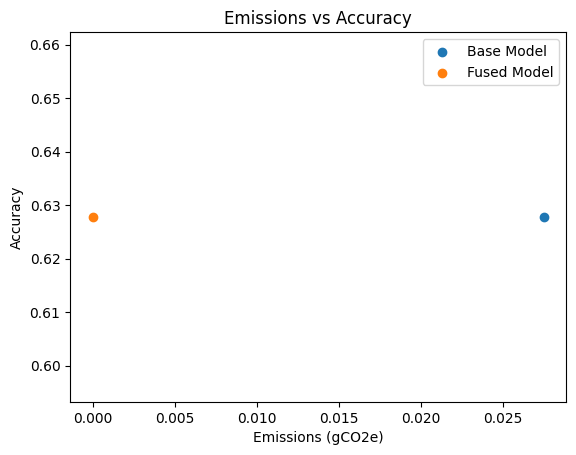

In [16]:
plt.scatter(model_emissions, base_model_acc, label="Base Model")
plt.scatter(fused_model_emissions, fused_model_acc, label="Fused Model")

plt.xlabel("Emissions (gCO2e)")
plt.ylabel("Accuracy")

plt.legend()

plt.title("Emissions vs Accuracy")

plt.show()

# Exemple avec la librairie *green_ai Made by Octo*

In [4]:
from green_ai.experimentation import torch_Experimentation

from green_ai.models import small_ConvModel, FusedModel

In [5]:
gr_model = small_ConvModel(
    height=HEIGHT,
    width=WIDTH,
    in_channels=CHANNELS,
    out_features=N_CLASSES,
    out_channels=256,
    stride=1,
)

gr_model_fused = FusedModel(model=gr_model)

gr_optimizer = torch.optim.Adam(gr_model.parameters(), lr=0.001)

gr_optimizer_fused = torch.optim.Adam(gr_model_fused.parameters(), lr=0.001)

In [ ]:
log_file = "logs/GREAI.csv"
log_id = "LayerFusion"

experiment = torch_Experimentation(
    models=[gr_model, gr_model_fused],
    optimizers=[gr_optimizer, gr_optimizer_fused],
    model_names=["model", "model_fused"],
    train_loader=trainloader,
    validation_set=True,
    validation_size=0.2,
    test_loader=testloader,
    loss_fn=torch.nn.CrossEntropyLoss(),
    epochs=1,
    metric_fn=sklearn.metrics.accuracy_score,
    device="cuda" if torch.cuda.is_available() else "cpu",
    log_file=log_file,
    log_id=log_id,
)

experiment.run_experiment()

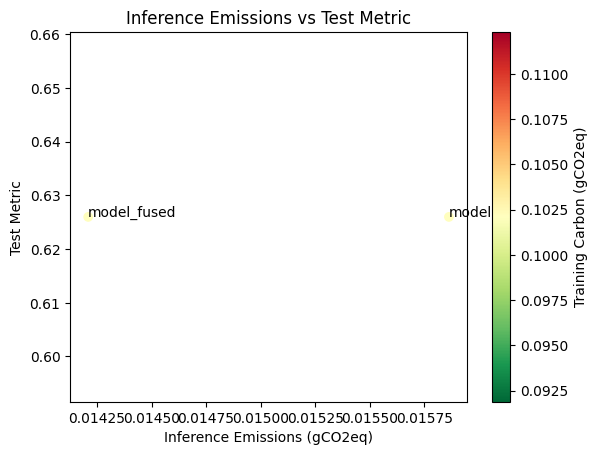

In [7]:
experiment.plot_inference_vs_score(option="carbon")

In [8]:
print(experiment.get_results())

{'model': {'train': {'time': 254.1065239906311, 'carbon': 0.10210341951658039}, 'test': {'loss': 1.0729912340164185, 'metric': 0.626}, 'inference': {'time': 3.7699668169021607, 'carbon': 0.01586230718644597}}, 'model_fused': {'train': {'time': 254.1065239906311, 'carbon': 0.10210341951658039}, 'test': {'loss': 1.0729912307739258, 'metric': 0.626}, 'inference': {'time': 3.361685037612915, 'carbon': 0.014209992505845944}}}


In [9]:
experiment.print_models_summary()

Summary for model:
small_ConvModel(
  (conv1): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (batchnorm_1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm_2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc): Linear(in_features=9216, out_features=10, bias=True)
  (relu): ReLU(inplace=True)
  (output_func): Identity()
)

Summary for model_fused:
FusedModel(
  (base_model): small_ConvModel(
    (conv1): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1))
    (conv2): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (batchnorm_1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (batchnorm_2): BatchNorm2d(256, eps=1e-05, moment